# Forest Cover and Cities

## Introduction

### Overview

This Notebook is a re-implementation of some of the maps relating to global forest cover, based upon the book Python Maps Geospatial Visualization with Python, by Adam Symington [https://locatepress.com/book/pymaps]

I decided to compare the forests around the UK's largest city, and Australia's largest city

### Data Sources

The data for forest cover came from  the EU SCIENCE HUB, 
Global Forest Monitoring [https://forobs.jrc.ec.europa.eu/GFC] [https://forobs.jrc.ec.europa.eu/GFC]

>The global forest cover map of 2020 version 2 is available for download by 10°x10° tiles. The tiling starts at 180°W and 80°N with tile ID “N80” and “W180”, respectively. Tiles over the ocean are not provided. The file format is GEOTIFF.

I also (for Sydney) discovered that I wanted a high-precision coastline, as using Cartopy's built-in coastlines led to have forests growing out to sea.  Fortunately, Geoscience Australia has a dataset called __Sydney Special 1:250 000 GIS Dataset__, located at [https://ecat.ga.gov.au/geonetwork/srv/eng/catalog.search#/metadata/64665]

As best as I can tell, this dataset contains shapefiles that would let you create the paper 1:250,000 map.  They have a shapefile called `seas`, that gives the polygons for Sydney Harbour, and the Pacific coastline.

----------------------------
## Implementation

### Load Magics

`watermark` gives reproducability information, `lab_black` ensures a consistent cell formatting

In [1]:
%load_ext watermark

In [2]:
%load_ext lab_black

### Load Packages

`shapely` handles geometries, `matplotlib` handles plotting, `cartopy` handles mapping, `rasterio` handles rasters 

In [3]:
# all imports should go here

import pandas as pd
import numpy as np

import shapely.geometry as sg

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io.shapereader import Reader

import matplotlib.pyplot as plt
import matplotlib

from collections import namedtuple

import rasterio
from rasterio.plot import show
from rasterio.enums import Resampling

---------------------

## Raster Data Load

The forest cover rasters are downloaded for 10 degree squares, and as luck would have it, for at least one of my maps I need two such rasters to cover the whole map I am plotting.  I create a list of the URLs for the GEOTIFF  rasters I have downloaded.

In [4]:
URL_E150_S30 = "C:\\Users\\donrc\\Downloads\\JRC_GFC2020_V2_S30_E150.tif"
URL_E140_S30 = "C:\\Users\\donrc\\Downloads\\JRC_GFC2020_V2_S30_E140.tif"
URL_W10_N60 = "C:\\Users\\donrc\\Downloads\\JRC_GFC2020_V2_N60_W10.tif"
URL_E0_N60 = (
    "C:\\Users\\donrc\\Downloads\\JRC_GFC2020_V2_N60_E0.tif"
)

URLS = [
    URL_E150_S30,
    URL_E140_S30,
    URL_W10_N60,
    URL_E0_N60,
]

Now create DataSetReader objects for each raster.  I show the bounding box, just to check the URLs are correct

In [5]:
forest_dsrs = [rasterio.open(url) for url in URLS]

_ = [
    print(f'DataSetReader {i} has bounds {(dsr.bounds)}')
    for i, dsr in enumerate(forest_dsrs)
]

DataSetReader 0 has bounds BoundingBox(left=150.0, bottom=-40.0, right=160.0, top=-30.0)
DataSetReader 1 has bounds BoundingBox(left=140.0, bottom=-40.0, right=150.0, top=-30.0)
DataSetReader 2 has bounds BoundingBox(left=-10.0, bottom=50.0, right=0.0, top=60.0)
DataSetReader 3 has bounds BoundingBox(left=0.0, bottom=50.0, right=10.0, top=60.0)


-------------------------

Now I create a helper function, that given a DataSetReader object, reads and returns the raster data, downscaled as specified.  I downscale the data to make processing times bearable, and a finer raster would not be visible on my small maps

In [6]:
def get_raster_data(dsr, scale_factor: float = 1.0 / 32):
    '''
    get_raster_data: read downscaled raster given DataSetReader

    Design:
    We usually expect scale_factor to be < 1, so as to reduce the
    size of the raster returned.

    Parameters:
    dsr: rasterio DataSetReader

    scale_factor: factor to inflate or deflate raster (default = 1/32)

    Returns:
    result of DataSetReader read() operation

    Limitations:
    No exception handling is done

    '''
    data2 = dsr.read(
        out_shape=(
            dsr.count,
            int(dsr.height * upscale_factor),
            int(dsr.width * upscale_factor),
        ),
        resampling=Resampling.nearest,
    )
    return data2


# end get_raster_data

I set the downscaling factor

In [7]:
#
# scaling factor to reduce raster size without affecting image quality (much)
#
upscale_factor = 1.0 / 32

-----------------------

## Map Generation

I create a function that, given a central latitiude and longitude, plots the rasters that cover a one degree square centered on that point

I define some `namedtuples` that make it clearer what the parameters being passed to the function.  For example, for a `Raster`, i bundle up the data of the raster together with the top latitude and left longitude

In [8]:
Point = namedtuple('Point', ['lon', 'lat'])

Raster = namedtuple(
    'Raster', ['data', 'top_lat', 'left_lon']
)

# define the centers of our two maps
sydney = Point(lat=-33.86, lon=151.17)
london = Point(lat=51.52, lon=-0.09)

I define a function to create a `matplotlib` `Figure`  object, given the central lat/lon, and the rasters needed to cover the 1 degree square (in Plate Carree projection).

Some points of interest:

* I use `cartopy` to read the shapefile, not `geopandas`

* I define a colormap where the no-data, and zero value colors are defined to be fully transparent

* I use the `cartopy` default color for water

* I use the  `matplotlib` color `green` for forests



In [9]:
def get_forest_figure(
    centre, forest_rasters, ocean_url: str
):
    '''
    get_forest_figure: generate a matplotlib Figure, 1 degree square with forest cover

    Parameters:

    centre: namedtuple(Point, [lon, lat])

    forest_rasters: [namedtuple(Raster [data, top_lat, left_lon]) ]

    ocean_url: path to shapefile holding ocean data: set to None if not relevant

    Returns:
    matplotlib Figure object

    Side Effects:
    prints statement of rasters plotted

    Design:

    If a shapefile for ocean is available, use that else just draw cartopy coastlines (if any)

    We expect the raster to be binary (Forest at the pixel, Yes=1/No=0, so use
    custom colormap where 0 -> fully transparent

    We use PlateCarrree for the map projection

    We expect a list of rasters to draw, because the 10 degree grid of forest cover datasets doesnt
    perfectly align with the 1 degree square we are mapping (ie we need to plot two rasters
    to cover map extent

    Limitations:
    1 Degree square extent hard coded

    Knowledge of 10 degree extent of rasters hard-coded

    Green as forest color in colormap hard-coded

    '''
    my_cmap = matplotlib.colors.ListedColormap(
        ["none", "green"]
    )

    fig, ax = plt.subplots(
        figsize=(12, 12),
        subplot_kw={'projection': ccrs.PlateCarree()},
    )

    # define the extent of the plot
    # currently at 1 degree square
    ax.set_extent(
        [
            centre.lon - 0.5,
            centre.lon + 0.5,
            centre.lat - 0.5,
            centre.lat + 0.5,
        ],
        crs=ccrs.PlateCarree(),
    )
    if ocean_url != None:
        # draw blue ocean (if any)
        ax.add_geometries(
            Reader(ocean_url).geometries(),
            ccrs.PlateCarree(),
            facecolor=cfeature.COLORS['water'],
        )
    else:

        # draw coastlines
        ax.coastlines(
            resolution='10m',
            alpha=0.6,
            color='gray',
        )
    # end if

    # plot the array of forest cover)
    # we know that the rasters are on 10 degree squares
    for raster in forest_rasters:
        print(
            f'plotting raster {raster.left_lon=:5.1f}, {raster.top_lat=:5.1f}'
        )
        pcm = ax.imshow(
            raster.data,
            cmap=my_cmap,
            extent=[
                raster.left_lon,
                raster.left_lon + 10,
                raster.top_lat - 10,
                raster.top_lat,
            ],
        )

    # plot marker at centre of 1 degree square
    ax.plot(
        [centre.lon],
        [centre.lat],
        color='red',
        marker='o',
        markersize=10,
        zorder=9,
        linewidth=0,
        transform=ccrs.PlateCarree(),
    )

    # configure gridlines:  we dont want labels outside the black image
    # alpha=0.4 makes for dim lines
    gl = ax.gridlines(
        color='gray',
        alpha=0.4,
        draw_labels=False,
        x_inline=False,
        y_inline=False,
    )

    return fig


# end

-------------------
### London

Build the two `Raster` namedtuples that cover our map of London

In [10]:
ldn_data = get_raster_data(forest_dsrs[2])
ldn_forest1 = Raster(
    ldn_data[0].copy(),
    left_lon=forest_dsrs[2].bounds.left,
    top_lat=forest_dsrs[2].bounds.top,
)
ldn_data = get_raster_data(forest_dsrs[3])
ldn_forest2 = Raster(
    ldn_data[0].copy(),
    left_lon=forest_dsrs[3].bounds.left,
    top_lat=forest_dsrs[3].bounds.top,
)

Create the London forest cover map.  We know we don't need to process a ocean shapefile

plotting raster raster.left_lon=-10.0, raster.top_lat= 60.0
plotting raster raster.left_lon=  0.0, raster.top_lat= 60.0


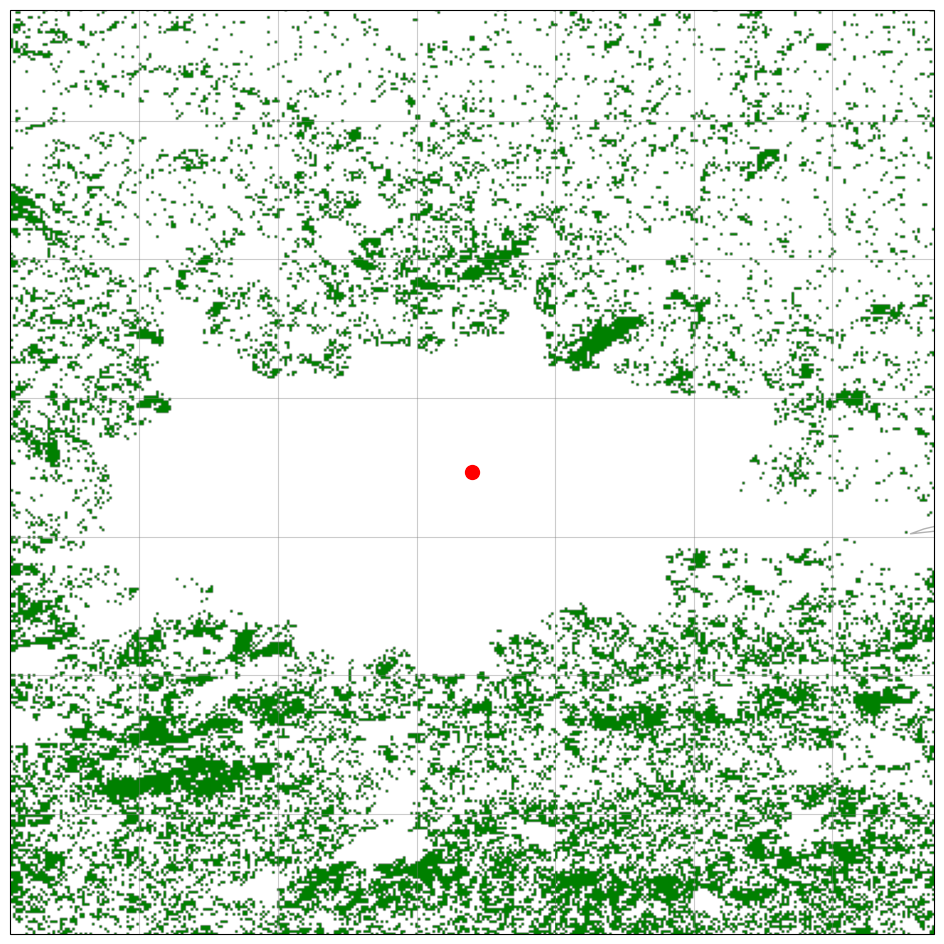

In [11]:
fig = get_forest_figure(
    london, [ldn_forest1, ldn_forest2], None
)
plt.show()

----------------

### Sydney

Build the  `Raster` namedtuple that cover our map of Sydney

In [12]:
syd_data = get_raster_data(forest_dsrs[0])
syd_forest1 = Raster(
    syd_data[0].copy(),
    left_lon=forest_dsrs[0].bounds.left,
    top_lat=forest_dsrs[0].bounds.top,
)

Create the Sydfney forest cover map.  Note that we know we need a high quality ocean, so we add a shapefile URL to our parameter list

plotting raster raster.left_lon=150.0, raster.top_lat=-30.0


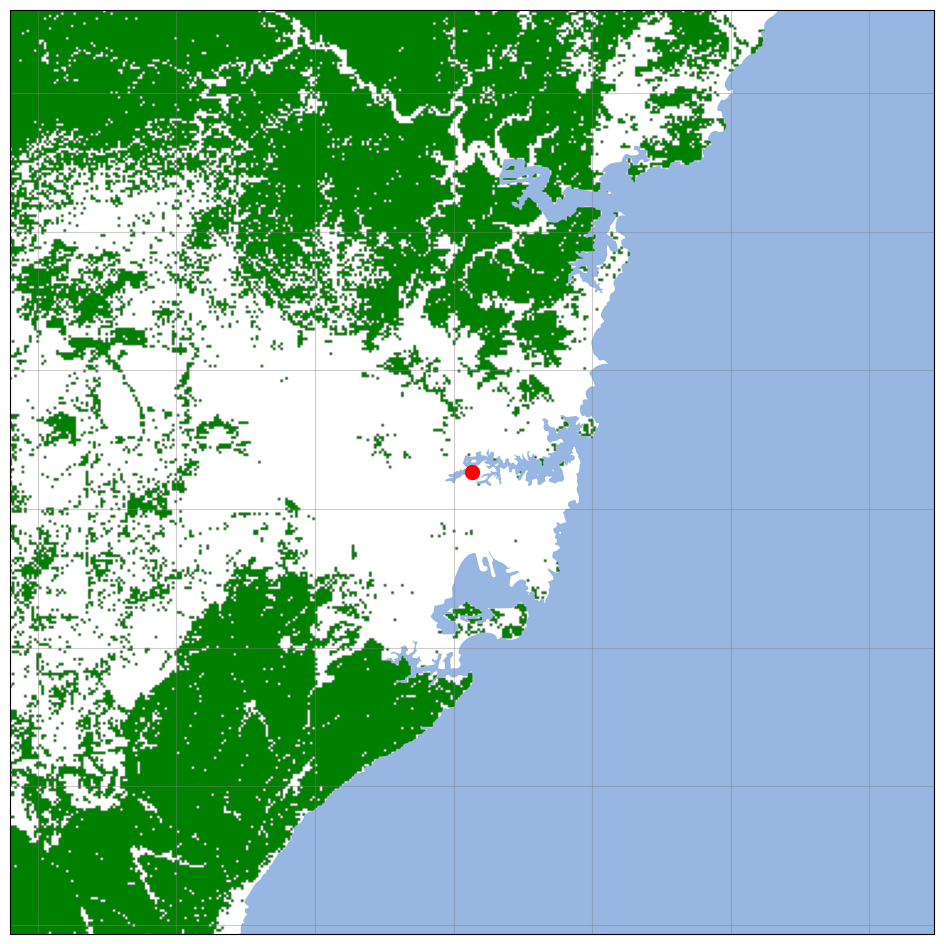

In [13]:
fig = get_forest_figure(
    sydney,
    [
        syd_forest1,
    ],
    "C:\\Data\\AustralianMappingDatasets\\Sydney\\i5605_seas.shp",
)
plt.show()

--------------------------------

## Conclusions

Just a quick impression, but in Sydney it is a lot easier to get to a quite large area of forest, than in London

Note that although `geopandas` is my usual go-to mapping package, it was not used here.

----------------------------
## Reproducability Information

In [14]:
%watermark

Last updated: 2025-05-22T14:17:56.855777+10:00

Python implementation: CPython
Python version       : 3.12.9
IPython version      : 9.0.2

Compiler    : MSC v.1929 64 bit (AMD64)
OS          : Windows
Release     : 11
Machine     : AMD64
Processor   : Intel64 Family 6 Model 170 Stepping 4, GenuineIntel
CPU cores   : 22
Architecture: 64bit



In [15]:
%watermark -co  -iv -v -h

Python implementation: CPython
Python version       : 3.12.9
IPython version      : 9.0.2

conda environment: pythonmaps

Hostname: INSPIRON16

rasterio  : 1.4.3
pandas    : 2.2.3
numpy     : 1.26.4
shapely   : 2.0.6
cartopy   : 0.24.1
matplotlib: 3.10.0

